# Stage 1: Binary Classification - Testing & Inference

This notebook allows you to test the trained **Binary Classification Model (Healthy vs Wound)**.

**Supported Modes:**
1. **Single Image**: Predict on a specific image path.
2. **Folder**: Predict on all images in a directory.
3. **Test Set**: Evaluate metrics (Accuracy, F1, AUC) on `test.csv`.

In [2]:
import os
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import timm
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Config
CONFIG = {
    "img_size": 224,
    "batch_size": 32,
    "num_workers": 0,
    "model_name": "tf_efficientnet_b0",
    "model_path": "../models/stage1_binary/best_model_fold_0.pth",
    "test_csv": "../data/loaders/test.csv",
    "root_dir": "../"
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda


In [3]:
# --- Helper Classes ---

class WoundDatasetDF(Dataset):
    def __init__(self, df, root_dir=None, transform=None, binary_mode=False):
        self.annotations = df
        self.root_dir = Path(root_dir) if root_dir else Path(".")
        self.transform = transform
        self.binary_mode = binary_mode
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        row = self.annotations.iloc[index]
        rel_path = row['path']
        rel_path = str(rel_path).replace('\\', os.sep).replace('/', os.sep)
        
        img_path = self.root_dir / rel_path
        
        try:
            image = Image.open(img_path).convert("RGB")
        except:
             # Fallback
            if rel_path.startswith(".."):
                 img_path = self.root_dir / rel_path[3:]
            try:
                image = Image.open(img_path).convert("RGB")
            except:
                image = Image.new('RGB', (224, 224), color='black')
            
        # Handle missing label for inference mode
        if 'label' in row:
            label_str = row['label']
            if self.binary_mode:
                label = 0 if str(label_str).lower() == 'healthy' else 1
            else:
                label = 0 # Default placeholder
        else:
            label = -1 # Unknown
            
        if self.transform:
            image = np.array(image)
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, torch.tensor(label, dtype=torch.float32)

def get_transforms():
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def load_model():
    model = timm.create_model(CONFIG['model_name'], pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(CONFIG['model_path'], map_location=device))
    model.to(device)
    model.eval()
    return model

# Load Model Once
model = load_model()
transforms = get_transforms()
print("Model Loaded Successfully.")

Model Loaded Successfully.


## 1. Single Image Inference
Change `image_path` to test a specific file.

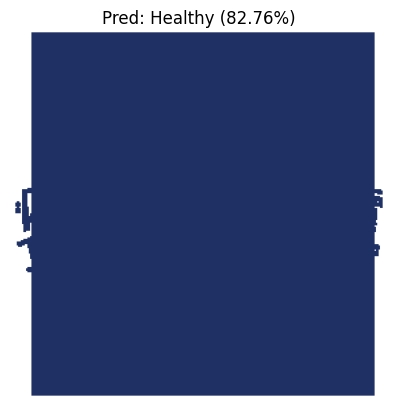

('Healthy', 0.8275864124298096)

In [ ]:
# def predict_image(image_path, model, transforms, device):
#     try:
#         image = Image.open(image_path).convert("RGB")
#         img_np = np.array(image)
#         aug = transforms(image=img_np)
#         img_tensor = aug['image'].unsqueeze(0).to(device)
        
#         with torch.no_grad():
#             output = model(img_tensor)
#             prob = torch.sigmoid(output).item()
            
#         pred_label = "Wound" if prob > 0.5 else "Healthy"
#         confidence = prob if prob > 0.5 else 1 - prob
        
#         plt.imshow(image)
#         plt.title(f"Pred: {pred_label} ({confidence:.2%})")
#         plt.axis('off')
#         plt.show()
        
#         return pred_label, confidence
#     except Exception as e:
#         print(f"Error: {e}")

# # Example Usage - Replace with absolute path if needed
# predict_image("../data/raw/type_classification/cut/cut_01525.jpg", model, transforms, device)
# predict_image("E:\\download\\logo.png", model, transforms, device)
# predict_image("F:\\Housepital-AI\\Housepital-AI\\dfu_dataset\\Wound Multitask Data Set\\Fresh Images\\male (346).jpg", model, transforms, device)
# predict_image("E:\\download\\A 3D character of a small boy with a friendly and supportive demeanor, similar to Samir the Study Buddy. The character should have short, tidy hair with a playful tuft, bright and expressive eyes, and casual clothing.png", model, transforms, device)

# Data Visualization & Splitting Verification

This notebook verifies the output of `split_data.py`. We check:
1. **Test Set Distribution**: Ensuring the 15% hold-out set is stratified.
2. **Cross-Validation Folds**: Ensuring the 5 folds are balanced and representative.

## 2. Test Set Evaluation
Evaluate on `test.csv`.

In [5]:
if os.path.exists(CONFIG['test_csv']):
    df_test = pd.read_csv(CONFIG['test_csv'])
    test_ds = WoundDatasetDF(df_test, root_dir=CONFIG['root_dir'], transform=transforms, binary_mode=True)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=False)
    
    preds_all = []
    targets_all = []
    
    print("Running Evaluation...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds_all.extend(torch.sigmoid(outputs).cpu().numpy())
            targets_all.extend(labels.cpu().numpy())
            
    preds_binary = (np.array(preds_all) > 0.5).astype(int)
    targets_all = np.array(targets_all)
    
    print("Classification Report:")
    print(classification_report(targets_all, preds_binary, target_names=['Healthy', 'Wound']))
    print(f"ROC AUC: {roc_auc_score(targets_all, preds_all):.4f}")
else:
    print("Test CSV not found.")

Running Evaluation...


100%|██████████| 110/110 [00:51<00:00,  2.14it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.95      0.97      0.96       600
       Wound       0.99      0.99      0.99      2908

    accuracy                           0.98      3508
   macro avg       0.97      0.98      0.97      3508
weighted avg       0.99      0.98      0.98      3508

ROC AUC: 0.9962
